# Tutorial: how to generate power-law surrogates


This notebook is designed very briefly to illustrate generation of different types of power-law surrogates from synthetic data and an empirical time series.

## Import source code and basic libraries

In [1]:
from constrained_power_law_surrogates import gen_typ_p_l_surrogate, gen_power_law_surr_list, ident_cut_off_const, estim_scale_exp
# 
import numpy as np
import sys

## Input sequence

Store your input sequence into the variable *seq*

Generate from a power-law with chosen exponent and lower cut-off:

In [2]:
gamma = 2; x_min = 3; N = 10;
seq = gen_typ_p_l_surrogate(gamma, x_min, N)
print(seq)

[3, 3, 3, 6, 4, 4, 3, 9, 3, 4]


Alternatively, read it from data

Read input sequence from counts of distinct words in Moby Dick by Herman Melville:

In [3]:
seqtext = open("time-series/words.txt").read().split("\n")
seq = [int(x) for x in seqtext[:10]]
print(seq)

[14086, 6414, 6260, 4573, 4484, 4040, 2917, 2483, 2374, 1942]


Read input sequence from sequences of energy released by earthquakes:

In [4]:
seqtext = open("time-series/energy.txt").read().split("\n")
seq = [int(x) for x in seqtext[:64]]
print(seq)

[1, 2, 21, 6, 1, 27, 1, 1, 1, 1, 3, 3, 1, 2, 7, 1, 1, 1, 1, 2, 8, 14, 2, 2, 1, 11, 10, 1, 2, 14, 4, 1, 1, 3, 1, 2, 97, 24, 3, 2, 1, 1, 5, 1, 1, 2, 12, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 21, 4, 50, 1]


## Estimating the cut-off

Estimate lower cut-off x_min by minimising KS-distance from maximum likelihood power-law

In [5]:
(x_min, _, _, _, _) = ident_cut_off_const(seq)
print("Identified lower cut-off: " + str(x_min))

Identified lower cut-off: 1


Discard data below lower cut-off

In [6]:
seq = [int(np.round(val)) for val in seq if val >= x_min]

## Surrogate methods

### This is the list and small description of the methods to generate (surrogate) time series

In [7]:
surrogate_methods = ['obse','know','cons','typi','boot','shuf','mark','ordi']
method_description={
    'obse':'Original observation',
    'know':'Power-law surrogate with known scale exponent',
    'cons':'Constrained power-law surrogate',
    'typi':'Typical power-law surrogate',
    'boot':'Bootstrap surrogate',
    'shuf':'Shuffle surrogate',
    'mark':'Constrained Markov order power-law surrogate',
    'ordi':'Constrained ordinal pattern power-law surrogate',
    'unknown':'Unknown input surr_method surrogate'
}
method_names = {
    'obse':'Observed',
    'know': 'Known exponent',
    'cons':'Constrained',
    'typi':'Typical',
    'boot':'Bootstrapped',
    'shuf':'Shuffled',
    'mark':'Markov',
    'ordi':'Ordinal pattern',
    'unknown':'Unknown'
}

You can choose one of the methods to generate the surrogate of the input sequence *seq* as:

In [8]:
surr_seq_list = gen_power_law_surr_list(seq,surr_method='cons')
print(surr_seq_list)

[[2, 1, 2, 2, 1, 1, 679, 1, 3, 16, 15, 3, 12, 1, 1, 1, 7, 1, 1, 1, 2, 1, 1, 1, 6, 1, 2, 3, 12, 11, 70, 1, 1, 1, 2, 1, 1, 7, 8, 21, 2, 1, 2, 1, 1, 1, 1, 3, 1, 1, 1, 2, 1, 1, 1, 25, 3, 1, 1, 3, 1, 1, 18, 8]]


Here are surrogates from all the methods:

In [9]:
for method in surrogate_methods:
    print("Using method: " + method + " to generate: " + method_description[method])
    if (method == 'know'):#Power-law surrogates with known scale exponent
        surr_seq_list = gen_power_law_surr_list(seq, surr_method=method, x_min=x_min, num_surr=2, scale_exp=2)#num_surr=2 independently realised surrogates, scale exponent 2
    elif (method == 'mark'):#Constrained Markov order power-law surrogate
        surr_seq_list = gen_power_law_surr_list(seq, surr_method=method, x_min=x_min, num_surr=2, o=1, b=3, num_trans=10**5)#num_surr=2 independently realised surrogates, Markov order o=1 using Markov states defined using bins of logarithmic length log(b) = log(3), Metropolis algorithm with num_trans=10**5 transitions
    elif (method == 'ordi'):#Constrained ordinal pattern power-law surrogate
        surr_seq_list = gen_power_law_surr_list(seq, surr_method=method, x_min=x_min, num_surr=2, L=16, num_trans=10**5)#num_surr=2 independently realised surrogates, Ordinal patterns of length L=16, Metropolis algorithm with num_trans=10**5 transitions
    else:
        surr_seq_list = gen_power_law_surr_list(seq, surr_method=method, x_min=x_min, num_surr=2)#num_surr=2 independently realised surrogates
    print(surr_seq_list,"\n")

Using method: obse to generate: Original observation
[[1, 2, 21, 6, 1, 27, 1, 1, 1, 1, 3, 3, 1, 2, 7, 1, 1, 1, 1, 2, 8, 14, 2, 2, 1, 11, 10, 1, 2, 14, 4, 1, 1, 3, 1, 2, 97, 24, 3, 2, 1, 1, 5, 1, 1, 2, 12, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 21, 4, 50, 1], [1, 2, 21, 6, 1, 27, 1, 1, 1, 1, 3, 3, 1, 2, 7, 1, 1, 1, 1, 2, 8, 14, 2, 2, 1, 11, 10, 1, 2, 14, 4, 1, 1, 3, 1, 2, 97, 24, 3, 2, 1, 1, 5, 1, 1, 2, 12, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 21, 4, 50, 1]] 

Using method: know to generate: Power-law surrogate with known scale exponent
[[3, 2, 5, 1, 2, 1, 1, 1, 5, 3, 1, 8, 18, 1, 1, 3, 4, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 2, 2, 2, 39, 134, 1, 1, 1, 22, 4, 1, 1, 1, 1, 3, 1, 1, 2, 1, 5, 1, 1, 3, 2, 7, 1, 1, 1, 1, 1, 1, 12, 1, 2, 1, 1], [6, 1, 2, 1, 5, 2, 1, 1, 3, 1, 16, 1, 4, 3, 2, 5, 2, 4, 2, 1, 3, 1, 2, 1, 1, 1, 4, 1, 2, 2, 1, 1, 1, 1, 1, 4, 2, 1, 1, 1, 1, 2, 1, 1, 6, 3, 1, 1, 1, 2, 8, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1]] 

Using method: cons to generate: Constrained power-law surr

Here is how to make plots comparing surrogates with the originally observed sequence:

59555 observations above estimated lower cut-off x_min = 1, of which we will consider 1024 consecutive values starting from a randomly chosen point.


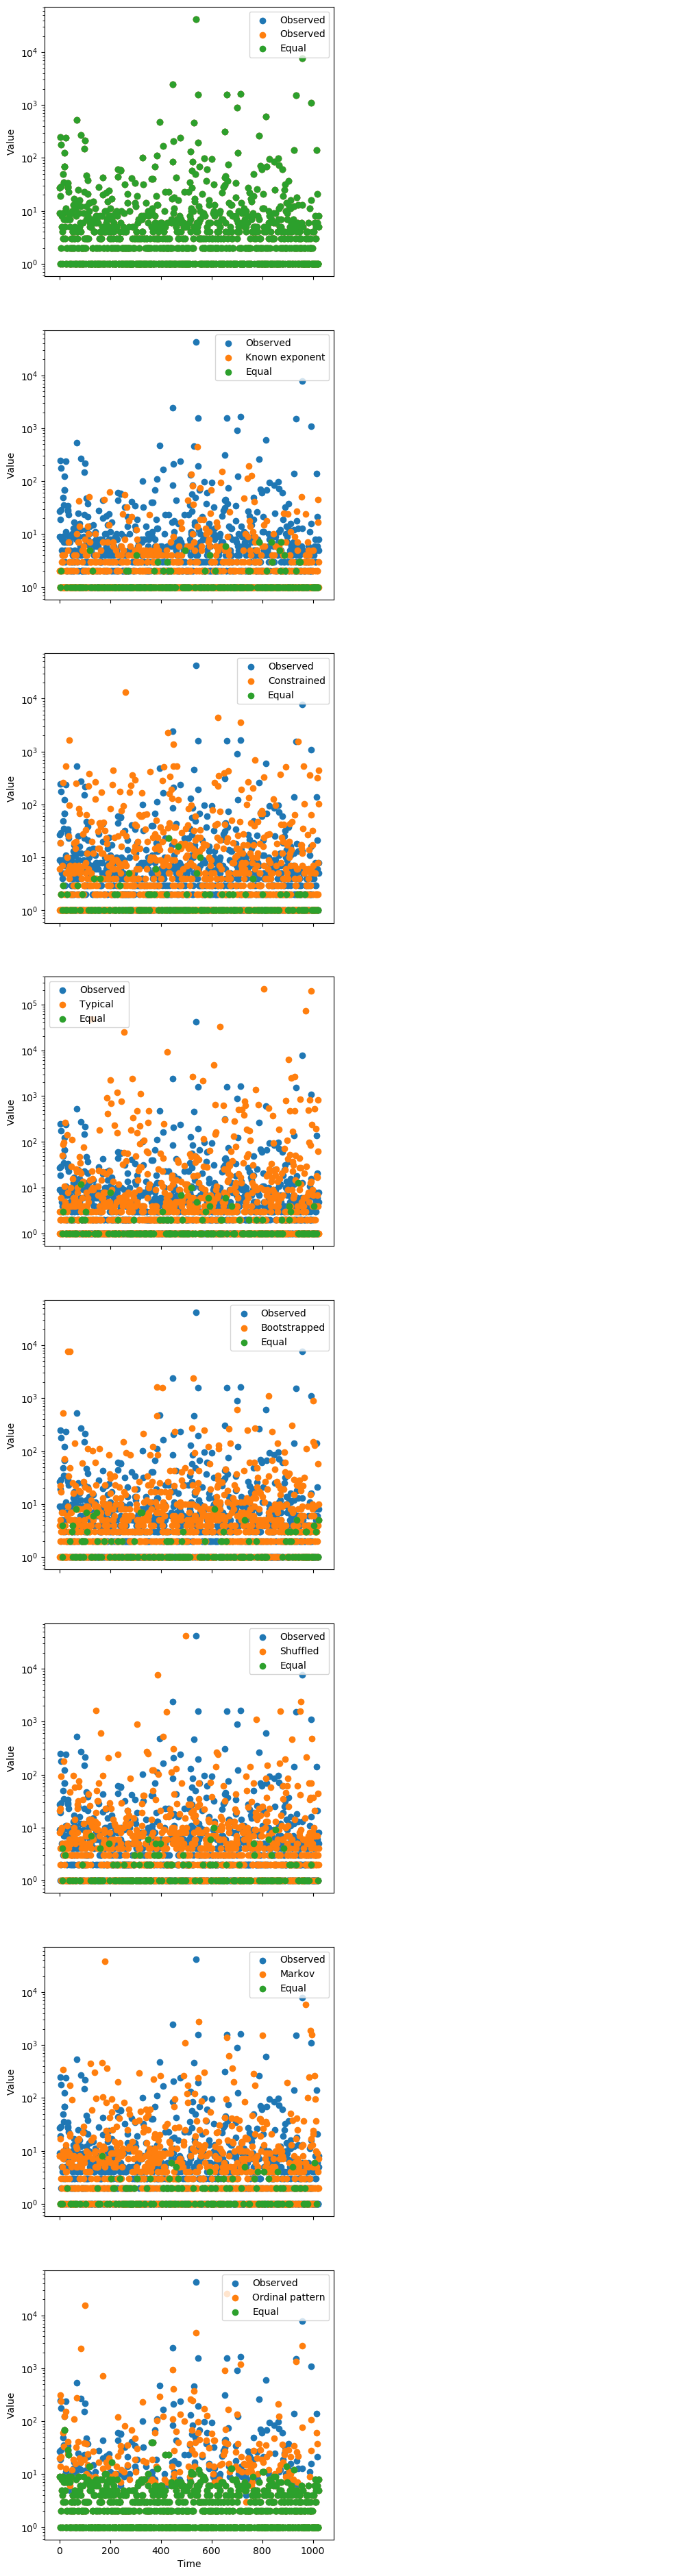

In [10]:
# Load empirical data from text file
# Generate surrogates from this empirical data using different methods
# Juxtapose each surrogate with original observation.
# 

NMax = 1024# Maximum length of time series

# Load observation from text file
# file_name_str = 'time-series/normed-flares.txt'; #x_min = 1;, N = 1,711, NG = 1,711
file_name_str = 'time-series/energy.txt'; #x_min = 1;, N = 59,555, NG = 59,555

data = np.loadtxt(file_name_str)

#Estimate lower cut-off x_min by minimise KS-distance from maximum likelihood power-law
(x_min, _, _, _, _) = ident_cut_off_const(data)
seq = [int(np.round(val)) for val in data if val >= x_min]
N0 = len(seq)

N0 = len(data)
if (N0 > NMax):
    N = NMax
    start_point = np.random.randint(0, N0 - N)
    seq = seq[start_point:(start_point + N)]
else:
    N = N0
    
print(str(N0) + ' observations above estimated lower cut-off x_min = ' + str(x_min) + ', of which we will consider ' + str(N) + ' consecutive values starting from a randomly chosen point.');

#The list of surrogates to be considered, and their names
surr_method_list = ['obse', 'know', 'typi', 'cons', 'boot', 'shuf', 'mark', 'ordi']
surr_method_name_list = ['Observed', 'Known exponent', 'Typical', 'Constrained', 'Bootstrapped', 'Shuffled', 'Markov', 'Ordinal pattern']

scale_exp = 2#Known scale exponent (Known scale exponent "know" surrogates only)
o = 1#Markov order (Markov order surrogates "mark" only)
b = 3#Use bins of logarithmic width log(b) (Markov order surrogates "mark" only)
L = 16#Length of ordinal patterns (ordinal pattern surrogates "ordi" only)
num_trans = 10**5#Number of transitions (Markov order "mark" and ordinal pattern surrogates "ordi" only)

#Generate and plot realisation of each type of surrogate
num_surr_types = len(surrogate_methods)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(num_surr_types, 2, sharex='col', sharey='none', figsize=(2*6, 6*num_surr_types))
for i in range(num_surr_types):
    surr_method = surrogate_methods[i]
    surr_method_name = method_names[surr_method]
    surr_val_seq_list = gen_power_law_surr_list(seq, surr_method=surr_method, x_min=x_min, num_surr=1, scale_exp=scale_exp, o=o, b=b, L=L, num_trans=num_trans)
    surr_val_seq = surr_val_seq_list[0]
    scale_exp_m_l = estim_scale_exp(surr_val_seq, x_min)#Find maximum likelihood scale exponent of surrogate realisation
    match_seq = [seq[ii] if surr_val_seq[ii] == seq[ii] else np.nan for ii in range(N)]
    ax_subplot = ax[i][0]
    ax_subplot.scatter(list(range(N)), seq)
    ax_subplot.scatter(list(range(N)), surr_val_seq)
    ax_subplot.scatter(list(range(N)), match_seq)
    ax_subplot.set_yscale('log')
    ax_subplot.legend(labels=['Observed', surr_method_name, 'Equal'])
    ax_subplot.set_ylabel('Value')
    ax_subplot = ax[i][1]
    ax_subplot.axis('off')
ax[-1][0].set_xlabel('Time')
plt.show()